This time watching the video, seeing how it can be improved

In [71]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from tqdm.notebook import tqdm
from  keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPool2D
from tensorflow.keras.preprocessing.image import load_img
#to convert to one hot encoding
from tensorflow.keras.utils import to_categorical

Load the Dataset

In [72]:
train_dir = '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train'
test_dir = '/Users/naomigong/Coding/ML Projects/facialEmotions/test/test'

In [73]:
def load_dataset(directory):
    input_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory + '/' +label):
            image_path = os.path.join(directory, label, filename)
            input_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return input_paths, labels

In [74]:
train = pd.DataFrame()
train['images'], train['emotion'] = load_dataset(train_dir)
train = train.sample(frac =1).reset_index(drop = True)
train.head()

happy Completed
sad Completed
fear Completed
surprise Completed
neutral Completed
angry Completed
disgust Completed


,images,emotion
0,/Users/naomigong/Coding/ML Projects/facialEmot...,neutral
1,/Users/naomigong/Coding/ML Projects/facialEmot...,fear
2,/Users/naomigong/Coding/ML Projects/facialEmot...,neutral
3,/Users/naomigong/Coding/ML Projects/facialEmot...,surprise
4,/Users/naomigong/Coding/ML Projects/facialEmot...,sad


In [75]:
train.shape

(28709, 2)

In [76]:
test = pd.DataFrame()
test['images'], test['emotion'] = load_dataset(test_dir)
test = test.sample(frac =1).reset_index(drop = True)
test.head()

happy Completed
sad Completed
fear Completed
surprise Completed
neutral Completed
angry Completed
disgust Completed


,images,emotion
0,/Users/naomigong/Coding/ML Projects/facialEmot...,fear
1,/Users/naomigong/Coding/ML Projects/facialEmot...,neutral
2,/Users/naomigong/Coding/ML Projects/facialEmot...,happy
3,/Users/naomigong/Coding/ML Projects/facialEmot...,surprise
4,/Users/naomigong/Coding/ML Projects/facialEmot...,surprise


In [77]:
test.shape

(7178, 2)

Exploratory Data Analysis

<Axes: xlabel='count', ylabel='emotion'>

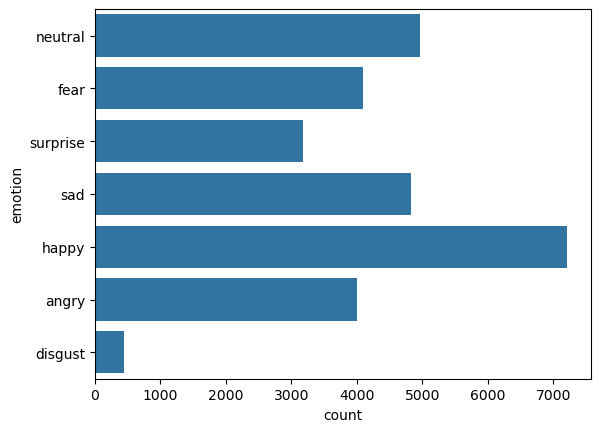

In [78]:
sns.countplot(train['emotion'])

Resolution: 48x48


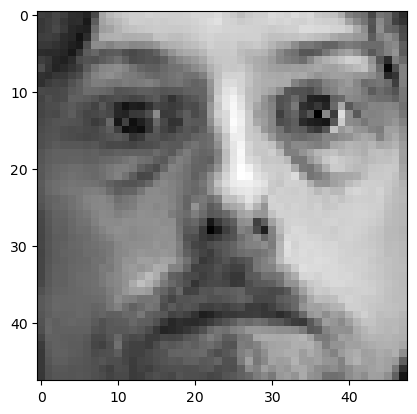

In [79]:
#load one image
from PIL import Image
image = Image.open(train['images'][1])
width, height = image.size
#get resolution
print(f"Resolution: {width}x{height}")
plt.imshow(image, cmap = 'gray')

Feature Extraction

In [80]:


def extract_features(images):
    features = []
    #tqdm gives you loading bar
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)

    #reshape the array so you can feed it into the model
    #len(features) gives you the width 
    #48, 48, 1 (height, width , 1 dimension)
    features = features.reshape(len(features), 48, 48, 1)
    return features




In [81]:
train_feature = extract_features(train['images'])
test_feature = extract_features(test['images'])

  0%|          | 0/28709 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

In [82]:
#these are the images
x_train = train_feature/255.0
x_test = test_feature/255.0


Now we want to label encode the emotion labels

In [83]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
ytrain = encoder.fit_transform(train['emotion'])
ytest = encoder.fit_transform(test['emotion'])
print(ytrain)
print(ytest)


[4 2 4 ... 3 2 5]
[2 4 3 ... 3 0 4]


In [84]:
input_shape = (48, 48, 1)
output_class = 7

In [85]:
ytrain = to_categorical(ytrain, num_classes= 7)
ytest = to_categorical(ytest, num_classes = 7)

Model Creation

In [86]:
model = tf.keras.models.Sequential()
model.add(Conv2D(8, kernel_size = (5, 5), activation = 'relu', input_shape = input_shape))
model.add(MaxPool2D(2,2))
#We can add drop out layers so we dont overfit -- if we dont do augmenttation we should do it
model.add(Dropout(0.4))
model.add(Conv2D(8, kernel_size = (5, 5), activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(8, kernel_size = (5, 5), activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(7, activation = 'softmax'))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [88]:
history = model.fit(x = x_train, y = ytrain, batch_size = 128, epochs = 10, validation_data=(x_test, ytest))

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2433 - loss: 1.8375 - val_accuracy: 0.2471 - val_loss: 1.8378
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.2509 - loss: 1.8095 - val_accuracy: 0.2601 - val_loss: 1.7983
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.2599 - loss: 1.7847 - val_accuracy: 0.2829 - val_loss: 1.7514
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.2943 - loss: 1.7360 - val_accuracy: 0.3362 - val_loss: 1.6719
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.3200 - loss: 1.6917 - val_accuracy: 0.3649 - val_loss: 1.6142
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3372 - loss: 1.6590 - val_accuracy: 0.3798 - val_loss: 1.5927
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3424 - loss: 1.6473 - val_accuracy: 0.3826 - val_loss: 1.5853
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.3483 - loss: 1.6312 - val_accu

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

Testing with Images

In [120]:
import random
image_index = random.randint(0, len(test))
print("Original Output: ", test['emotion'][image_index])
#1 sample
#48 48 is pixel
#last 1 is channels
prediction = model.predict(x_test[image_index].reshape(1, 48, 48, 1))


prediction_label = encoder.inverse_transform(np.array([prediction.argmax()]))

Original Output:  neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Predicted Output:  ['happy']


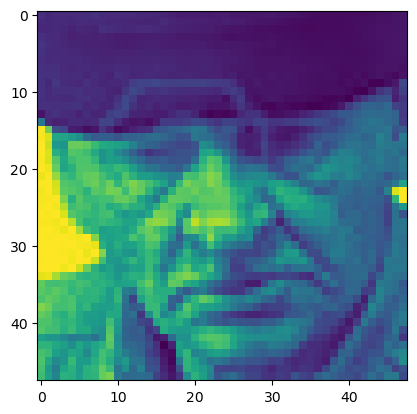

In [121]:
print("Predicted Output: ", prediction_label)
plt.imshow(x_test[image_index].reshape(48,48))